In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime as dt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data_folder = os.path.join(os.getcwd(), 'Datasets')
data_path = os.path.join(os.getcwd(), 'data')
gold_folder = os.path.join(data_folder, 'Gold')
fin_folder = os.path.join(data_folder, 'Financial')

In [3]:
corp = 'Corp'
house = 'House'

In [24]:
path_list = []
corp_list = []
house_list = []
gold_df = pd.DataFrame()
for root, dirs, files in os.walk(os.path.join(os.getcwd(), 'Datasets')):


    for file in files:
            if file.endswith(".csv"):
                pname = os.path.join(root, file)
                col_name = pname.split('/')[-1]
                col_name = col_name.split('.')[0]
                
                
                if corp in col_name:
                    corp_list.append(col_name)
                    
                if house in col_name:
                    house_list.append(col_name)

                path_list.append(pname)

                blank_df = pd.read_csv(pname)

                # Check for different format
                if len(blank_df.columns) > 3:
                    blank_df = pd.read_csv(pname)
                    blank_df.rename(columns={'Date':'date', 'Close': col_name}, inplace=True)
                    blank_df.index = pd.to_datetime(blank_df['date'])
                    blank_df.drop(columns=['date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

                else:  
                    blank_df = pd.read_csv(pname, names=['date', col_name], skiprows=1)
                    # Datetime at the index
                    blank_df.index = pd.to_datetime(blank_df['date'])
                    # Drop the old 'date' column
                    blank_df.drop(columns='date', inplace=True)


                # Fullstop value on nulls needs removing
                blank_df = blank_df[blank_df[col_name] != '.']
                # Convert the gold column to float (fullstops prevented this)
                blank_df[col_name] = pd.to_numeric(blank_df[col_name])
                # Resample on the month
                blank_df = blank_df.resample("M").mean()
                # Interpolate NaN's
                blank_df = blank_df.interpolate(method='polynomial', order=2)


                #print(blank_df)
                if len(path_list) < 2:
                    gold_df = blank_df
                    
                else:
                    gold_df = gold_df.merge(blank_df, how='outer', left_index=True, right_index=True)
                    #gold_df = gold_df.reset_index().merge(blank_df, how='outer', left_on=gold_df.index, right_on=blank_df.index).set_index('date').drop(columns='key_0')


print(str(len(path_list)) + ' = length')
#print(corp_list)
#print(house_list)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


49 = length


In [25]:
j = 'NASDAQ'
k = 'SandP'
l = 'Dow_Jones_Industrial'
gold_df['market_average'] = gold_df[[j, k, l]].mean(axis=1)

In [26]:
min_date = '1969-01-01'

In [27]:
# Eliminate data before the 'min_date' which is when the gold data begins
gold_df = gold_df.loc[gold_df.index > min_date]

In [28]:
gold_col = 'GOLDAMGBDollarD228NLBM'

In [29]:
leading_list = [gold_col, 'Industrial Production_Manufacturing (NAICS)', 'All Employees, Retail Trade', 'Unemployment_Rate', 'IndustrialProductionGoldSilver21222S', 'Federal Debt Held by Federal Reserve Banks', 'FEDFUNDS', 'Fed Debt_Total Public Debt as Perc of GDP', ]
leading_list

['GOLDAMGBDollarD228NLBM',
 'Industrial Production_Manufacturing (NAICS)',
 'All Employees, Retail Trade',
 'Unemployment_Rate',
 'IndustrialProductionGoldSilver21222S',
 'Federal Debt Held by Federal Reserve Banks',
 'FEDFUNDS',
 'Fed Debt_Total Public Debt as Perc of GDP']

In [30]:
# Filter the dataframe and keep only the columns listed.
gold_df = gold_df.filter(leading_list, axis=1)

In [31]:
"""The following code is used for making crude extapolation assumptions for economic indicators"""

'The following code is used for making crude extapolation assumptions for economic indicators'

In [41]:
gold_df_fit = gold_df.loc[(gold_df.index > min_date) & (gold_df.index < '2024-01-01')]

idx = pd.date_range(start=dt.date(2020, 8, 31), end=dt.date(2024, 8, 31), freq='M')

gold_df_fit1 = gold_df_fit.copy().reindex(idx)

gold_df_fit = gold_df_fit.append(gold_df_fit1).reset_index()

gold_df_fit['index'] = pd.to_datetime(gold_df_fit['index'])
gold_df_fit.index = gold_df_fit['index']
gold_df_fit.drop(['index'], axis=1, inplace=True)

In [79]:
# Create High, mid, low cases.
gold_df_low = gold_df_fit.copy()
gold_df_mid = gold_df_fit.copy()
gold_df_high = gold_df_fit.copy()

In [80]:
for i in gold_df_fit.columns:
    frac_null = gold_df_mid[i].isna().sum() /len(gold_df_mid)
    print(i, ':', frac_null)

GOLDAMGBDollarD228NLBM : 0.07174887892376682
Industrial Production_Manufacturing (NAICS) : 0.13004484304932734
All Employees, Retail Trade : 0.07473841554559044
Unemployment_Rate : 0.07623318385650224
IndustrialProductionGoldSilver21222S : 0.13004484304932734
Federal Debt Held by Federal Reserve Banks : 0.10164424514200299
FEDFUNDS : 0.07473841554559044
Fed Debt_Total Public Debt as Perc of GDP : 0.08370702541106129


In [81]:
# Fit the end point value for the high df
gold_df_high.iloc[-1, gold_df_fit.columns.get_loc('Federal Debt Held by Federal Reserve Banks')] = 7500
gold_df_high.iloc[-1, gold_df_fit.columns.get_loc('FEDFUNDS')] = -2
gold_df_high.iloc[-1, gold_df_fit.columns.get_loc('Industrial Production_Manufacturing (NAICS)')] = 90
gold_df_high.iloc[-1, gold_df_fit.columns.get_loc('All Employees, Retail Trade')] = 15000
gold_df_high.iloc[-1, gold_df_fit.columns.get_loc('Unemployment_Rate')] = 10
gold_df_high.iloc[-1, gold_df_fit.columns.get_loc('IndustrialProductionGoldSilver21222S')] = 80
gold_df_high.iloc[-1, gold_df_fit.columns.get_loc('Fed Debt_Total Public Debt as Perc of GDP')] = 150

In [82]:
# Fit the end point value for the mid df
gold_df_mid.iloc[-1, gold_df_fit.columns.get_loc('Federal Debt Held by Federal Reserve Banks')] = 4500
gold_df_mid.iloc[-1, gold_df_fit.columns.get_loc('FEDFUNDS')] = 0
gold_df_mid.iloc[-1, gold_df_fit.columns.get_loc('Industrial Production_Manufacturing (NAICS)')] = 110
gold_df_mid.iloc[-1, gold_df_fit.columns.get_loc('All Employees, Retail Trade')] = 16000
gold_df_mid.iloc[-1, gold_df_fit.columns.get_loc('Unemployment_Rate')] = 7.8
gold_df_mid.iloc[-1, gold_df_fit.columns.get_loc('IndustrialProductionGoldSilver21222S')] = 100
gold_df_high.iloc[-1, gold_df_fit.columns.get_loc('Fed Debt_Total Public Debt as Perc of GDP')] = 120

In [83]:
# Fit the end point value for the low df
gold_df_low.iloc[-1, gold_df_low.columns.get_loc('Federal Debt Held by Federal Reserve Banks')] = 4000
gold_df_low.iloc[-1, gold_df_low.columns.get_loc('FEDFUNDS')] = 2
gold_df_low.iloc[-1, gold_df_low.columns.get_loc('Industrial Production_Manufacturing (NAICS)')] = 120
gold_df_low.iloc[-1, gold_df_low.columns.get_loc('All Employees, Retail Trade')] = 17000
gold_df_low.iloc[-1, gold_df_low.columns.get_loc('Unemployment_Rate')] = 6.0
gold_df_low.iloc[-1, gold_df_low.columns.get_loc('IndustrialProductionGoldSilver21222S')] = 125
gold_df_low.iloc[-1, gold_df_fit.columns.get_loc('Fed Debt_Total Public Debt as Perc of GDP')] = 95

In [84]:
interpolation_list = ['Industrial Production_Manufacturing (NAICS)', 'All Employees, Retail Trade', 'Unemployment_Rate', 'IndustrialProductionGoldSilver21222S', 'Federal Debt Held by Federal Reserve Banks', 'FEDFUNDS', 'Fed Debt_Total Public Debt as Perc of GDP']
hml_list = [gold_df_low, gold_df_mid, gold_df_high]
# Interpolate for the null values
for j in hml_list:
    for i in interpolation_list:
        j[i] = j[i].interpolate(method='linear', limit_direction='both')

In [85]:
for i in gold_df_mid.columns:
    frac_null = gold_df_mid[i].isna().sum() /len(gold_df_mid)
    print(i, ':', frac_null)

GOLDAMGBDollarD228NLBM : 0.07174887892376682
Industrial Production_Manufacturing (NAICS) : 0.0
All Employees, Retail Trade : 0.0
Unemployment_Rate : 0.0
IndustrialProductionGoldSilver21222S : 0.0
Federal Debt Held by Federal Reserve Banks : 0.0
FEDFUNDS : 0.0
Fed Debt_Total Public Debt as Perc of GDP : 0.0


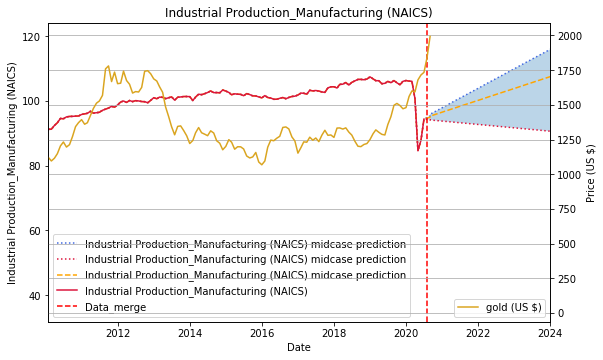

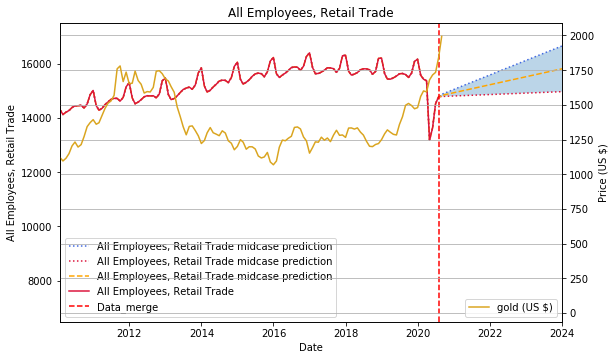

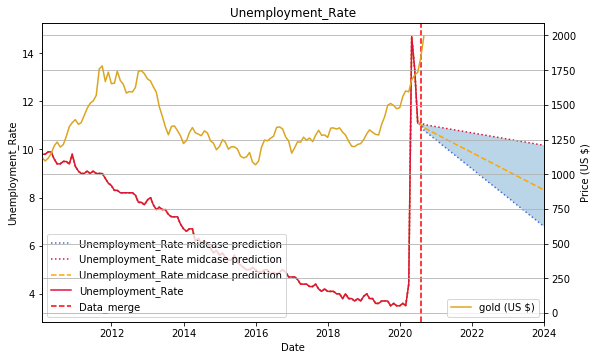

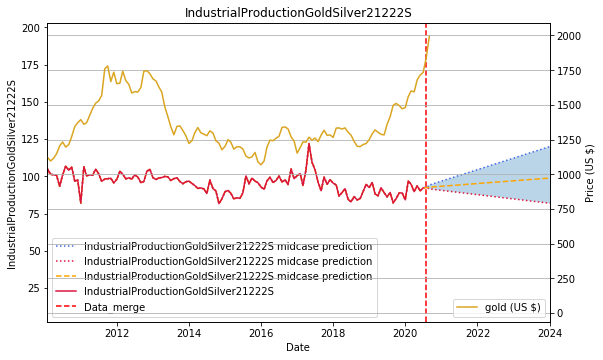

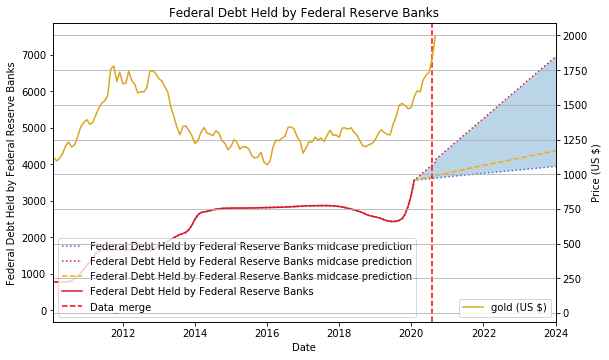

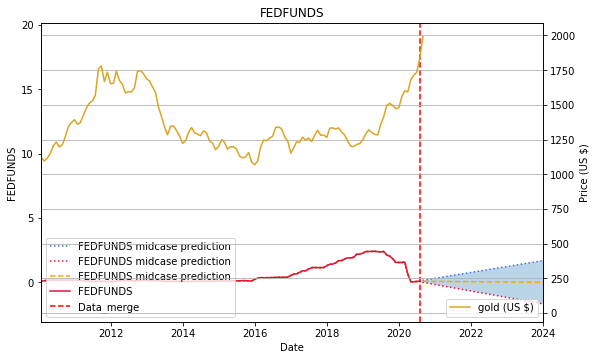

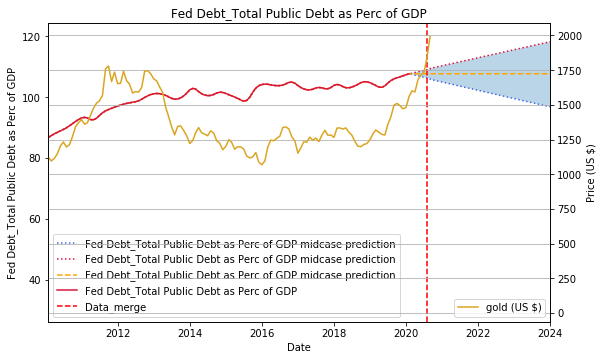

In [86]:
# Plot each of the 'extrapolate_list' attributes. The estimates look good and represent a 'best' case.
for i in interpolation_list:
    # Visualising the Linear Regression results.
    fig, ax1 = plt.subplots()
    j = i
    #k = 'Industrial Production_Manufacturing (NAICS)1'

    ax1.plot(gold_df_mid.index, gold_df_low[j], label=i + ' midcase prediction', c='royalblue', linestyle='dotted')
    ax1.plot(gold_df_mid.index, gold_df_high[j], label=i + ' midcase prediction', c='crimson', linestyle='dotted')
    ax1.plot(gold_df_mid.index, gold_df_mid[j], label=i + ' midcase prediction', c='orange', linestyle='dashed')
    ax1.plot(gold_df_fit.index, gold_df_fit[j], label=i, c='crimson', linestyle='solid')
    ax1.axvline(x=dt.date(2020, 8, 1), linestyle='--', color='red', label='Data_merge')
    #ax1.plot(gold_df_fit.index, gold_df_fit[j], label=j, c='mediumturquoise')
    
    ax1.fill_between(gold_df_high.index, gold_df_low[j],  gold_df_high[j], alpha=0.3)


    ax2 = ax1.twinx()
    ax2.plot(gold_df_fit.index, gold_df_fit['GOLDAMGBDollarD228NLBM'], label='gold (US $)', c='goldenrod')
    #ax2.plot(gold_df.index, gold_df['GOLD_shift'], label='gold shifted (US $)', c='gold')

    #ax1.ylim(0, 15)
    plt.title(j)
    plt.xlabel('Date')
    plt.grid()
    ax1.legend(loc=3)
    ax2.legend(loc=4)
    fig.set_size_inches(9, 5.5)

    #years = mdates.YearLocator()   # every year
    #ax1.xaxis.set_major_locator(years)
    #years_fmt = mdates.DateFormatter('%Y')
    #months = mdates.MonthLocator()  # every month
    #ax1.xaxis.set_major_formatter(years_fmt)
    #ax1.xaxis.set_minor_locator(months)

    ax1.set_xlim([dt.date(2010, 1, 26), dt.date(2024, 1, 1)])
    ax1.set_xlabel('Date')
    ax1.set_ylabel(j)
    ax2.set_ylabel('Price (US $)')

In [74]:
# Export the polished dataframe to re-import after modelling.
gold_df_low.to_csv(os.path.join(os.getcwd(), "data_export", "gold_df_low.csv"))
gold_df_mid.to_csv(os.path.join(os.getcwd(), "data_export", "gold_df_mid.csv"))
gold_df_high.to_csv(os.path.join(os.getcwd(), "data_export", "gold_df_high.csv"))

In [75]:
lmh_list = ['low', 'mid', 'high']
for i, j in zip(hml_list, lmh_list):
    # df_y is target to predict, in this case the price of gold
    df_y = i[[gold_col]].copy()
    # df_train contains the columns we will use to predict the price of gold
    df_train = i.copy()
    df_train.drop(columns=[gold_col], inplace=True)
    
    # Instead of randomly splitting the data we will select a date to test 'blind' from
    date_slice = '2016-01-01'
    
    # Data split according to the date. 'train'=before date, 'test'=after.
    X_train = df_train.loc[df_train.index < date_slice]
    X_test = df_train.loc[df_train.index >= date_slice]
    y_train = df_y.loc[df_y.index < date_slice]
    y_test = df_y.loc[df_y.index >= date_slice]
    
    # Export these four dataframes for later.
    X_train.to_csv(os.path.join(data_path, "train", "train_x_" + j + ".csv"))
    y_train.to_csv(os.path.join(data_path, "train", "train_y_" + j + ".csv"))
    X_test.to_csv(os.path.join(data_path, "test", "test_x_" + j + ".csv"))
    y_test.to_csv(os.path.join(data_path, "test", "test_y_" + j + ".csv"))